## 实验：神经网络学习

### 实验概要

神经网络存在合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为 **学习**，在课程刚开始的感知机模型中，我们通过手工指定权重与偏置来模拟神经网络的构建与预测。实际上，深度学习神经网络的核心特点之一，便在于能通过梯度下降算法，自动调节各层的权重与偏置，最终得到一个用于预测的模型。

### 实验目标

在本实验中，我们将结合之前实现过的各个概念，建立一个完整的神经网络 —— 它能通过输入数据获得预测输出；通过损失函数，计算预测输出与真实结果之间的误差；通过梯度下降算法模型，调节神经网络的权重与偏置参数，并再次执行预测输出，与损失对比；如此循环最终得到一个可用于预测的网络模型。

首先，我们通过 **`scikit-learn`** 的 `datasets` 模块生成测试数据，并且通过 `sklearn.linear_model` 模块调用逻辑回归模型，以此来演示并说明逻辑回归模型无法对非线性分布数据实现分类。之后，我们将通过纯 Python 代码，在不借助第三方模型依赖库的前提下，建立一个完整的神经网络。最后，我们将对比选择不同的隐藏层数量对模型拟合的影响。

#### 神经网络设计

建立一个三层神经网络，包括一个输入层、一个隐含层和一个输出层。

- 输入层节点个数由数据维度决定，为 2
- 输出层节点数由类的数量决定，为 2
  - 因为我们只有 2 个类，所以实际上只需要一个输出节点就可以预测 0 或 1，但是有 2 个会使以后扩展网络到更多的类变得更容易)
- 输入层输入 x 和 y 的值，输出层输出类的概率

<img src="img/nn-3-layer-network_09.png" width="60%">

#### 隐含层设置

对于隐含层，我们可以选择隐含层的维度（隐含层节点数），隐含层节点数越多，模型越复杂，学习能力越强。但同时计算代价也相应提高，同时过拟合的风险也越大。我们还需要为隐含层使用激活函数，激活函数将输入转换为输出。非线性激活函数一个重要作用就是是的我们能拟合非线性模型。常见的激活函数有 `tanh`、`sigmoid`、`Relu` 等。在这里，我们使用 **`tanh`**。这些激活函数还有一个很好的特点，就是它们的导数可以使用原函数来表示，如：`tanh`的导数可以表示为 $1-\tanh^2 x$ ，这对后面的 `1` 计算很有用。

因为输出为概率，所以在输出层的激活函数采用 `softmax` 函数，这是一种将原数据转变为概率的常见方法。当然，`softmax` 常被用于多分类的问题。

### 1. 导入库

首先，我们通过导入机器学习库生成测试数据集，并且通过调用 **`scikit-learn`** 中的 **逻辑回归** 模型，通过可视化分类说明为什么单一的线性模型无法对复杂的数据集进行分类。由于本章的实验目标在于不借助任何第三方库的前提下实现深度学习的各种核心理论概念，因此， **`scikit-learn`** 在这里仅仅充当生成数据与演示的功能，并不会将 **`scikit-learn`** 作为后续操作的依赖库库。

In [1]:
# 导入sklearn数据集模块，仅用于生成测试数据
import sklearn.datasets      
# 导入sklearn线性模型模块，仅用于演示逻辑回归线性模型无法对复杂的数据集进行分类
import sklearn.linear_model  

正如上文提及，在实际操作中，我们仅使用 Python 的科学计算基础运算库 **`Numpy`** 与数据可视化绘图库 **`Matplotlib`**，进行神经网络构建与学习算法实现。

In [2]:
# 导入numpy科学计算库
import numpy as np               
# 导入matplotlib数据可视化绘图库
import matplotlib.pyplot as plt  

# 魔法指令，使matplotlib图形直接在 Jupyter Notebook 中显示
%matplotlib inline
# 定义绘制图形画布尺寸
plt.rcParams['figure.figsize'] = (6.0, 6.0) 

### 2. 生成测试数据

使用 sklearn 中自带的 `make_moons()` 函数，生成两类以交叉半圆形态分布的测试数据，为机器学习算法提供分类测试样本，命令格式与默认值如下：

`sklearn.datasets.make_moons(n_samples=100, *, shuffle=True, noise=None, random_state=None)`，其中 ——

- **`n_numbers`:** 生成样本数量
- **`shuffle`:** 是否打乱
- **`noise`:** 默认是 None，数据集是否加入高斯噪声
- **`random_state`:** 生成随机种子，给定一个 int 型数据，能够保证每次生成数据相同。

详细说明请[查阅官方文档](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

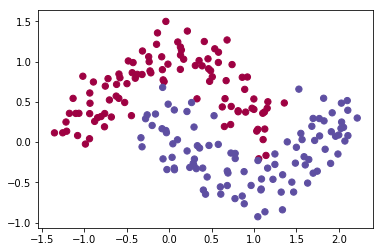

In [3]:
# 生成200个样本测试数据，噪音为0.2标准偏差
X, y = sklearn.datasets.make_moons(200, noise=0.20) 

# 绘制数据分布图
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral) 

从上图可知：

- 数据集包括 2 类，红色点和蓝色点。
- 数据是非线性可分的，所以不能直接使用一条直线进行分割，需要用到非线性的一些技术方法。
- 你不用担心特征工程，神经网络能很好的提取出特征，这也是神经网络的优势之一。

### 3. 逻辑回归

首先，使用逻辑回归进行分类演示。在 scikit-learn 中，有 `LogisticRegression` 和 `LogisticRegressionCV`，其中 `LogisticRegression` 和 `LogisticRegressionCV` 的主要区别是 `LogisticRegressionCV` 使用了交叉验证来选择正则化系数 C。而 `LogisticRegression` 需要自己每次指定一个正则化系数。除了交叉验证，以及选择正则化系数 C 以外，`LogisticRegression` 和 `LogisticRegressionCV` 的使用方法基本相同。

在本实验中，我们采用 `sklearn.linear_model.LogisticRegressionCV()` 函数调用逻辑回归，详细说明请[查阅官方文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

In [4]:
# 调用LogisticRegressionCV模型
clf = sklearn.linear_model.LogisticRegressionCV() 
# 使用调用的LogisticRegressionCV模型拟合数据集
clf.fit(X, y)                                     

LogisticRegressionCV()

### 4. 定义决策边界可视化函数

In [5]:
def plot_decision_boundary(pred_func):
    
    # 设置最小值和最大值，并给它一些填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

使用 `clf.predict()` 函数，用训练好的模型预测数据 x，并且绘制出决策边界：

Text(0.5,1,'Logistic Regression')

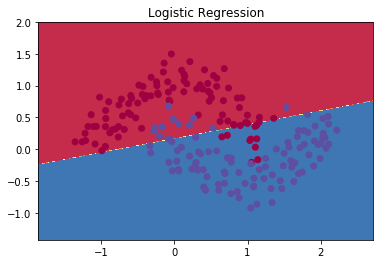

In [6]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

从逻辑回归的决策边界看到，由于数据集为非线性可分，无法用一条直线进行分开。

### 5. 设置神经网络常量

下面，我们开始通过神经网络对上面的非线性分布数据集进行分类预测。首先设置基本常量：

In [7]:
# 训练集大小
num_examples = len(X) 
# 输入维度
nn_input_dim = 2      
# 输出维度
nn_output_dim = 2     

# 学习率
epsilon = 0.01       
# 正则化系数
reg_lambda = 0.01    

### 6. 定义损失值求解函数

神经网络的预测使用 **正向传播**，对于我们的神经网络，正向传播的输出计算如下：

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

其中 ——

- $z_i$ 是第 `i` 层输入的加权和（含偏置）
- $a_i$ 是第 `i` 层输入经过激活函数后的输出
- $W_1, b_1, W_2, b_2$ 就是网络参数，也是神经网络需要学习的参数，你可以把它们想象成在网络层之间转换数据的矩阵。根据矩阵的乘法，我们可以很容易计算各参数的矩阵维度，如果隐含层节点为 500，那么我们可以知道 
    - $W_1 \in \mathbb{R}^{2\times500}$
    - $b_1 \in \mathbb{R}^{500}$
    - $W_2 \in \mathbb{R}^{500\times2}$
    - $b_2 \in \mathbb{R}^{2}$

这就是为什么增加隐含层，计算代价变大的原因了。

In [8]:
def calculate_loss(model):
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    # 这里直接调用 np.tanh 函数计算双曲正切元素
    a1 = np.tanh(z1)      
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    
    # 使用交叉熵计算损失
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

### 7. 定义梯度下降函数

梯度下降函数的核心是参数学习更新，从而获得最小的损失函数值。

#### 参数学习更新

参数学习就是找到 ($W_1, b_1, W_2, b_2$) 是的预测值与我们的实际值误差最小。这在里，引入损失函数的概念，损失函数就是用来表示误差的方法。**softmax** 的常见损失函数选择交叉熵。如果我们有 $N$ 个训练样本以及 $C$ 类 ，那么损失函数可以用预测值 $\hat{y}$ 和实际值 $y$ 表示如下:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

上述公式即交叉熵损失函数的多分类数学表现形式。

要找到最小的损失值，此时问题就是一个最优化问题。我们可以使用梯度下降法进行求解。而梯度下降法通常包括很多种，如:

- 批量梯度下降
- 随机梯度下降：当数据是随机选择的 mini batch 数据时，被称为：**随机梯度下降法（Stochastic Gradient Descent, SGD）**。**随机** 指的是随机选择的的意思，因此，随机梯度下降法是 **对随机选择的数据进行的梯度下降法**
- 小批量下降（mini-batch）

这里采用最基本的批量梯度下降。将损失值作为输入，求出损失函数对各参数的导数: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$。为了计算和更新参数，就要使用反向传播算法进行求解。反向传播具体过程不演示。应用反向传播公式，我们得到如下结果：

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

In [9]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    #初始化权重和偏置
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    model = {}
    
    # 梯度下降
    for i in range(0, num_passes):

        # 正向传播
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # 反向传播
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # 添加正则化项
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # 参数更新
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # 为模型分配新的参数
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # 输出损失值.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### 8. 定义预测函数

从 `build_model()` 主函数返回的 **`model`** 字典中，获取模型训练后得到的 $W_1, b_1, W_2, b_2$，参数值，代入数据集进行预测，并返回概率最高的类。

In [10]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

### 9. 训练三层神经网络

调用 `build_model()` 主函数，开始神经网络训练，并实时输出损失值；最后通过 matplotlib 绘制决策边界图形。

Loss after iteration 0: 0.430550
Loss after iteration 1000: 0.028978
Loss after iteration 2000: 0.026346
Loss after iteration 3000: 0.025526
Loss after iteration 4000: 0.025177
Loss after iteration 5000: 0.025004
Loss after iteration 6000: 0.024909
Loss after iteration 7000: 0.024853
Loss after iteration 8000: 0.024817
Loss after iteration 9000: 0.024793
Loss after iteration 10000: 0.024777
Loss after iteration 11000: 0.024765
Loss after iteration 12000: 0.024757
Loss after iteration 13000: 0.024750
Loss after iteration 14000: 0.024876
Loss after iteration 15000: 0.024790
Loss after iteration 16000: 0.024789
Loss after iteration 17000: 0.024790
Loss after iteration 18000: 0.024792
Loss after iteration 19000: 0.024794


Text(0.5,1,'Decision Boundary for hidden layer size 3')

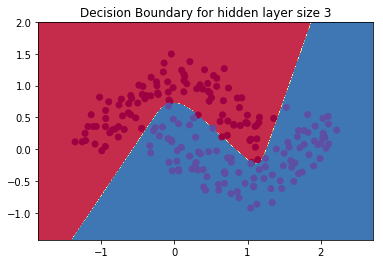

In [11]:
# 调用 build_model 主函数，开始神经网络训练，并实时输出损失值
model = build_model(3, print_loss=True) 

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

- 神经网络很好的将两类分割开来。

### 10. 改变隐含层大小

通过改变隐含层节点的大小，观察神经网络的分类情况。

> **模型训练预计需要 5 分钟，请耐心等待**

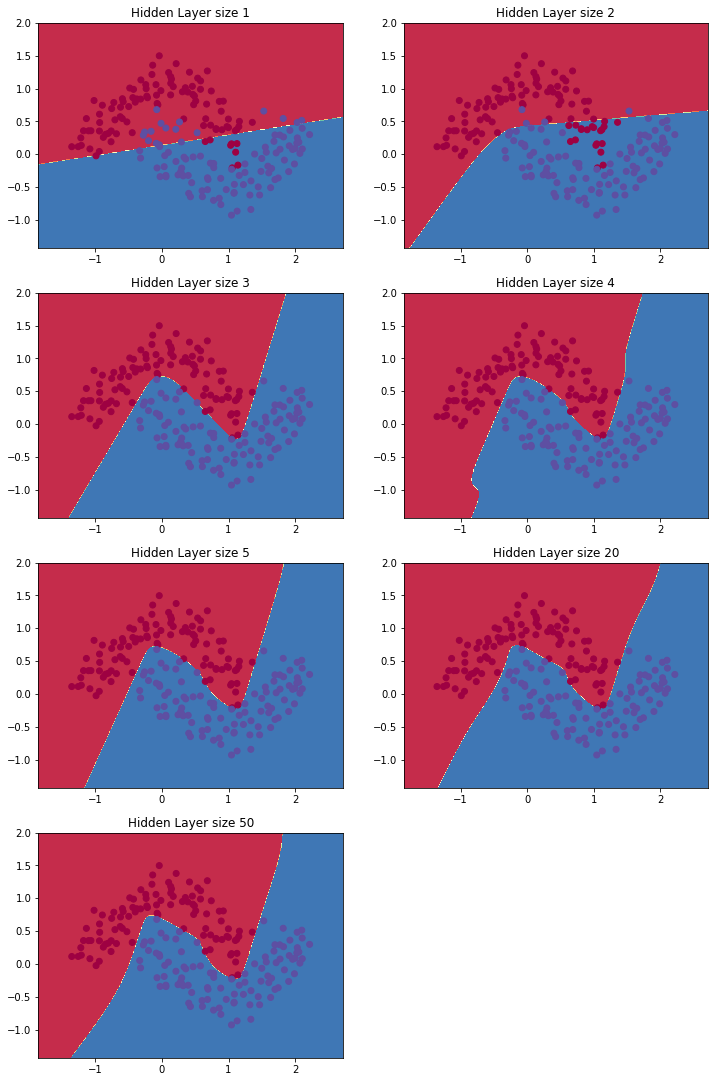

In [12]:
# 设置绘制图形画布尺寸
plt.figure(figsize=(12, 24)) 

# 分别绘制1/2/3/4/5/20/50层隐藏层的分类边界
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]     

for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
    
plt.show()

从图中可以看到，当隐含层节点较小时，随着节点增加，分类的效果越好。但当节点过高，则就会造成过拟合。因为高维模型是在“记忆”数据而不是拟合模型，所以它的泛化能力很差，在测试集上表现也会很差，对于过拟合，我们可以添加正则化来限制模型的复杂度，当然，选择最好的维度代价最小。对比上面各个隐藏层数量的决策边界可以发现，将隐藏层设置为 3，能获得最佳的拟合效果。与我们之前在调用 `build_model()` 主函数时输出的参数是一致的。

### 实验小结

在本实验中，你结合之前实现过的各个深度学习理论：权重值、偏置、激活函数、三层神经网络、损失函数、梯度下降、正向传播、反向传播（在下一节马上讨论）等概念，建立一个完整的神经网络。首先，我们通过 scikit-learn 的 datasets 模块生成测试数据，并且通过 sklearn.linear_model 模块调用逻辑回归模型，以此来演示并说明逻辑回归模型无法对非线性分布数据实现分类。之后，我们将通过纯 Python 代码，在不借助第三方模型依赖库的前提下，建立一个完整的神经网络。最后，我们将对比选择不同的隐藏层数量对模型拟合的影响。